In [1]:
# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd # data wrangling
import seaborn as sns # data visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# For handling multiple files
from glob import glob

# for cat features
from category_encoders import OneHotEncoder

# For interactive dashboard
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

from sklearn.impute import SimpleImputer # Handling missing values
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline

# Disable the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action="ignore", category=Warning)

In [2]:
df = pd.read_csv('../data/smallsales.csv')

df = df.loc[df['price_cost'] != 0]

df1 = df.loc[df['category_id'] == 1]
df2 = df.loc[df['category_id'] == 2]
df3 = df.loc[df['category_id'] == 3]
df4 = df.loc[df['category_id'] == 4]

In [3]:
# Separate features from the target.
target = "sales"
features =["date","category_id","views","price_cost","price_retail"]
X = df[features] # dataframe
y = df[target] # series

y

403      0
404      0
405      0
406      0
407      0
        ..
18295    0
18296    0
18297    0
18298    0
18299    0
Name: sales, Length: 12140, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

# split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
y_mean = (y_train.mean())

y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt sales: ",round(y_mean, 2))

print("Baseline MAE: ", round(mean_absolute_error(y_train,y_pred_baseline),2))

Mean apt sales:  1.36
Baseline MAE:  2.38


In [6]:
model_lr = make_pipeline(

    OneHotEncoder(use_cat_names=True), # encode cat features
    SimpleImputer(), # imputation
    LinearRegression()) # build model

# fit the model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['date'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [7]:
# Predict the train data
y_pred_training = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)

# Compute MAE
print("Training MAE:", round(mean_absolute_error(y_train, y_pred_training),2))
print("Test data MAE:", round(mean_absolute_error(y_test, y_pred_test),2))

Training MAE: 2.76
Test data MAE: 3.3


In [8]:
rf = make_pipeline(

    # encode cat features
    OneHotEncoder(use_cat_names=True),

    # Imputation
    SimpleImputer(),

    # build model
    RandomForestRegressor(
        random_state=42)
    )

# fit the model
rf.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['date'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [9]:
# Predict the train data
y_pred_training = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Compute MAE
print(f"Training MAE:{round(mean_absolute_error(y_train, y_pred_training),2)}")
print(f"Test data MAE:{round(mean_absolute_error(y_test, y_pred_test),2)}")

Training MAE:0.52
Test data MAE:1.57


In [10]:
from sklearn.model_selection import GridSearchCV, cross_val_score

params = {
    "randomforestregressor__n_estimators": range(25, 100, 25),
    "randomforestregressor__max_depth": range(10, 50, 10)
}
params

{'randomforestregressor__n_estimators': range(25, 100, 25),
 'randomforestregressor__max_depth': range(10, 50, 10)}

In [11]:
[i for i in range(10, 50, 10)]
[j for j in range(25, 100, 25)]

[25, 50, 75]

In [12]:
model = GridSearchCV(
    rf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['date'],
                                                      use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 50, 10),
                         'randomforestregressor__n_estimators': range(25, 100, 25)},
             verbose=1)

In [13]:
cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
cv_results = pd.DataFrame(model.cv_results_)
model.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 75}

In [14]:
y_pred_training = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Compute MAE
print("Training MAE:", round(mean_absolute_error(y_train, y_pred_training),2))
print("Test data MAE:", round(mean_absolute_error(y_test, y_pred_test),2))

Training MAE: 1.3
Test data MAE: 1.72


In [15]:
import joblib
# Save Model
joblib.dump(model, '../artifacts/model_1.pkl')

# Loading Model
model = joblib.load('../artifacts/model_1.pkl')

# Make predictions
model.predict(X)


array([0.50320445, 0.50320445, 0.50320445, ..., 0.07698619, 0.04100893,
       0.04100893])

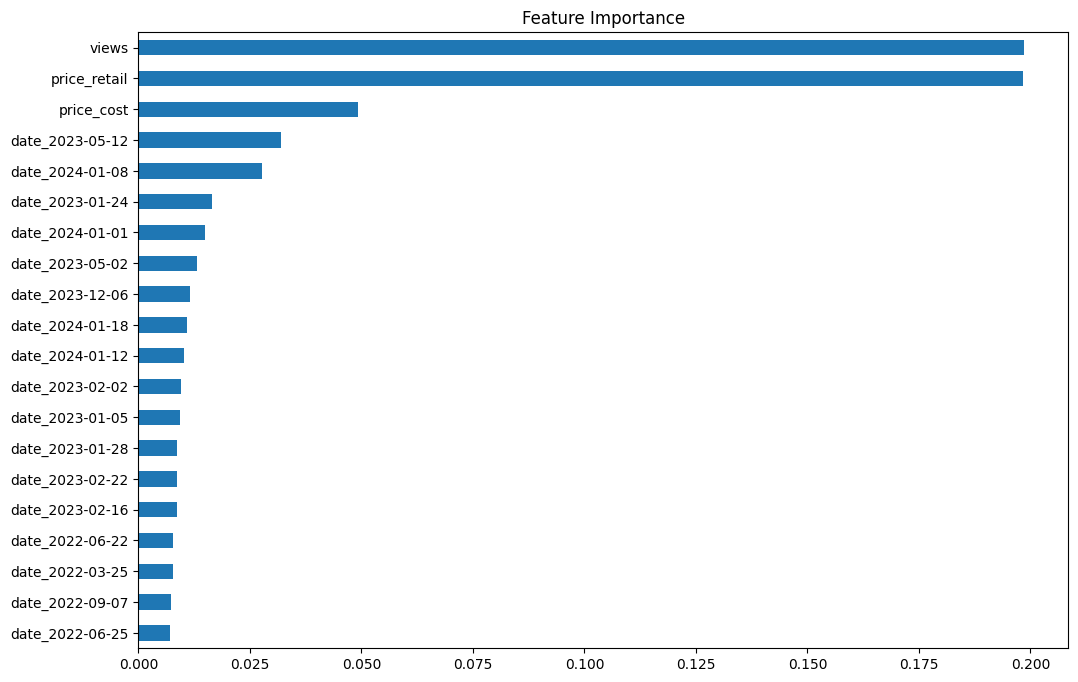

In [16]:
# Get coefficients of features
coefficients = rf.named_steps.randomforestregressor.feature_importances_

# Get feature names
features = rf.named_steps["onehotencoder"].get_feature_names()

# Create a Series of features
feat_imp = pd.Series(data=coefficients, index=features)

plot_feat_imp = feat_imp.sort_values(ascending=True).tail(20)
plot_feat_imp.plot(kind="barh", figsize=(12,8))
plt.title("Feature Importance")
plt.show()

In [17]:
def make_prediction(date, category_id, views, price_cost, price_retail):

    # Load the model
#     model = joblib.load(model_name)

    # Creating a dictionary for the new data
    data = {
        "date": date,
        "category_id": category_id,
        "views": views,
        "price_cost": price_cost,
        "price_retail": price_retail
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(0)[0]
    return f"Predicted sales: {prediction}"

In [19]:
make_prediction("2023-02-18",3,50,850,2000)

'Predicted sales: 1.0'